# Alcohol Consumption Prediction (Group 80)

In [188]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 7)

## Introduction
While not the most dangerous, alcohol is one of the most popular drugs in the world. Its consumption is not only popularized but normalized in modern society, regardless of any negative effects it may have. Many mental factors, such as extraversion and neuroticism, can affect how often one consumes alcohol. Furthermore, minimum legal ages fail to stop children and young teens from consuming alcohol. The question we aim to answer in this project is **"How can we predict the frequency of alcohol consumption based on certain aspects of an individual’s personality?"** The dataset we are using to answer this question is a quantified drug consumption dataset which contains information about 1885 unique individuals. Each entry contains 12 attributes such as personality measurements, age, ethnicity, etc., all of which are quantified and standardized. In addition, the dataset contains information regarding these individuals’ use of 18 drugs, ranging from chocolate to heroin, and one fictitious drug (semeron) to filter out liars. Each value in the drug columns reflects the recency of an individual’s use of a certain drug, ranging from “Never Used” to “Used in Last Day.”

## Preliminary Data Exploration
### Reading the data

In [189]:
drugs_data <- read_csv("data_sets_project/drug_consumption.csv", col_names = FALSE)
colnames(drugs_data) <- c("ID", "Age", "Gender", "Education", "Country", "Ethnicity", "Neuroticism", "Extraversion", 
                          "Openness_to_Experience", "Agreeableness", "Conscientiousness", "Impulsiveness", 
                          "Sensation_Seeing", "Alcohol", "Amphet", "Amyl", "Benzos", "Caff", "Cannabis", "Choc", "Coke",
                          "Crack", "Ecstacy", "Heorin", "LegalH", "LSD", "Meth", "Mushrooms", "Nicotine", "Semer", "VSA")
drugs_data

Rows: 1885 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (19): X14, X15, X16, X17, X18, X19, X20, X21, X22, X23, X24, X25, X26, X...
dbl (13): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ID,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness_to_Experience,Agreeableness,⋯,Ecstacy,Heorin,LegalH,LSD,Meth,Mushrooms,Nicotine,Semer,VSA,NA
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,⋯,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,⋯,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,⋯,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,⋯,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1886,-0.07854,0.48246,0.45468,-0.57009,-0.31685,1.13281,-1.37639,-1.27553,-1.77200,⋯,CL4,CL0,CL2,CL0,CL2,CL0,CL2,CL6,CL0,CL0
1887,-0.95197,0.48246,-0.61113,-0.57009,-0.31685,0.91093,-1.92173,0.29338,-1.62090,⋯,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL4,CL0,CL0
1888,-0.95197,-0.48246,-0.61113,0.21128,-0.31685,-0.46725,2.12700,1.65653,1.11406,⋯,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL6,CL0,CL2


### Selecting potential predictors among the variables

In [190]:
alcohol_data <- select(drugs_data, Age, Neuroticism,
                       Extraversion, Openness_to_Experience,
                       Agreeableness, Impulsiveness, Conscientiousness, Alcohol, Semer)
alcohol_data

Age,Neuroticism,Extraversion,Openness_to_Experience,Agreeableness,Impulsiveness,Conscientiousness,Alcohol,Semer
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.49788,0.31287,-0.57545,-0.58331,-0.91699,-0.21712,-0.00665,CL5,CL2
-0.07854,-0.67825,1.93886,1.43533,0.76096,-0.71126,-0.14277,CL5,CL4
0.49788,-0.46725,0.80523,-0.84732,-1.62090,-1.37983,-1.01450,CL6,CL0
-0.95197,-0.14882,-0.80615,-0.01928,0.59042,-1.37983,0.58489,CL4,CL2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
-0.07854,1.13281,-1.37639,-1.27553,-1.77200,0.52975,-1.38502,CL4,CL6
-0.95197,0.91093,-1.92173,0.29338,-1.62090,1.29221,-2.57309,CL5,CL4
-0.95197,-0.46725,2.12700,1.65653,1.11406,0.88113,0.41594,CL4,CL6


### Filtering out irrelevant observations


In [191]:
alcohol_data_filtered <- alcohol_data |>
                         filter(Semer == "CL0") |>
                         select(-Semer)
alcohol_data_filtered

Age,Neuroticism,Extraversion,Openness_to_Experience,Agreeableness,Impulsiveness,Conscientiousness,Alcohol
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.49788,-0.46725,0.80523,-0.84732,-1.62090,-1.37983,-1.01450,CL6
0.49788,-1.32828,1.93886,-0.84732,-0.30172,0.19268,1.63088,CL5
1.82213,-2.05048,-1.50796,-1.55521,-1.07533,-0.71126,1.13407,CL5
1.82213,1.37297,-0.15487,-0.17779,-1.92595,-0.71126,-1.51840,CL6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
-0.95197,-0.79151,0.00332,2.44904,0.76096,0.88113,-1.51840,CL5
2.59171,2.12700,-0.15487,2.44904,0.94156,-0.21712,-0.65253,CL5
-0.95197,-1.19430,1.74091,1.88511,0.76096,0.88113,-1.13788,CL5


### Summarizing the data
We are going to use only training data from this point on for our data exploration. 

In [192]:
alcohol_split <- initial_split(alcohol_data_filtered, prop = 0.75, strata = Alcohol)
alcohol_train <- training(alcohol_split)
alcohol_train

Age,Neuroticism,Extraversion,Openness_to_Experience,Agreeableness,Impulsiveness,Conscientiousness,Alcohol
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1.82213,0.04257,-0.69509,-1.11902,-0.45321,-1.37983,-0.40581,CL3
0.49788,-2.21844,0.47617,-1.82919,-0.76096,-1.37983,2.04506,CL3
0.49788,-0.24649,0.16767,-0.31776,-0.30172,0.88113,0.41594,CL3
-0.07854,0.04257,0.00332,-0.97631,-0.45321,0.52975,0.93949,CL2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1.09449,-0.92104,0.32197,-0.58331,-0.15487,-1.37983,1.13407,CL6
1.09449,-0.34799,-1.09207,-0.17779,-0.60633,-0.71126,0.58489,CL6
-0.07854,-0.46725,-1.50796,-0.58331,-0.30172,0.52975,-0.40581,CL6


First, we will see how many observations there are for each class of alcohol consumption.

In [193]:
alcohol_count <- group_by(alcohol_train, Alcohol) |>
                 summarize(n = n()) |>
                 bind_cols(c("Never Used", "Used over a Decade Ago", "Used in Last Decade",
             "Used in Last Year", "Used in Last Month", "Used in Last Week", "Used in Last Day"))
colnames(alcohol_count) <- c("Class", "No. of Individuals", "Meaning")
alcohol_count

New names:
• `` -> `...3`


Class,No. of Individuals,Meaning
<chr>,<int>,<chr>
CL0,18,Never Used
CL1,4,Used over a Decade Ago
CL2,9,Used in Last Decade
CL3,33,Used in Last Year
CL4,48,Used in Last Month
CL5,140,Used in Last Week
CL6,68,Used in Last Day


Most of the individuals consumed alcohol in the last week.

We also want find out the number of individuals in each of the age group categories.

In [194]:
age_count <- group_by(alcohol_train, Age) |>
                 summarize(n = n()) |>
                bind_cols(c("18-24", "25-34", "35-44", "45-54", "55-64", "65+"))
colnames(age_count) <- c("Age", "No. of Individuals", "Age Group")
age_count

New names:
• `` -> `...3`


Age,No. of Individuals,Age Group
<dbl>,<int>,<chr>
-0.95197,87,18-24
-0.07854,80,25-34
0.49788,54,35-44
1.09449,76,45-54
1.82213,18,55-64
2.59171,5,65+


There is an unequal distribution of participants among different age groups.

Now, we will find out the mean for the score for each of the personality attributes. 

In [195]:
attributes_mean <- alcohol_train |>
                   select(Neuroticism:Conscientiousness) |>
                   map_dfc(mean) |>
                   pivot_longer(cols = Neuroticism:Conscientiousness,
                               names_to = "Personality Trait",
                               values_to = "Mean (Standardized)") |>
                   bind_cols(c("34", "41", "47", "43", "NA", "42"),
                             c("12-60", "16-59", "24-60", "12-60", "NA", "17-59"))
colnames(attributes_mean) <- c("Personality Trait", "Mean (Standardized)", "Score/Measurement (Non-Standardized)", "Score Range (Non-Standardized)")
attributes_mean

New names:
• `` -> `...3`
• `` -> `...4`


Personality Trait,Mean (Standardized),Score/Measurement (Non-Standardized),Score Range (Non-Standardized)
<chr>,<dbl>,<chr>,<chr>
Neuroticism,-0.19729272,34,12-60
Extraversion,0.07895094,41,16-59
Openness_to_Experience,-0.27835937,47,24-60
Agreeableness,0.21698644,43,12-60
Impulsiveness,-0.30723306,NA,NA
Conscientiousness,0.29178066,42,17-59


### Visualizing the data
Since, we want to find out the distribution of alcohol consumption among individuals across different age categories, we will create a bar chart.

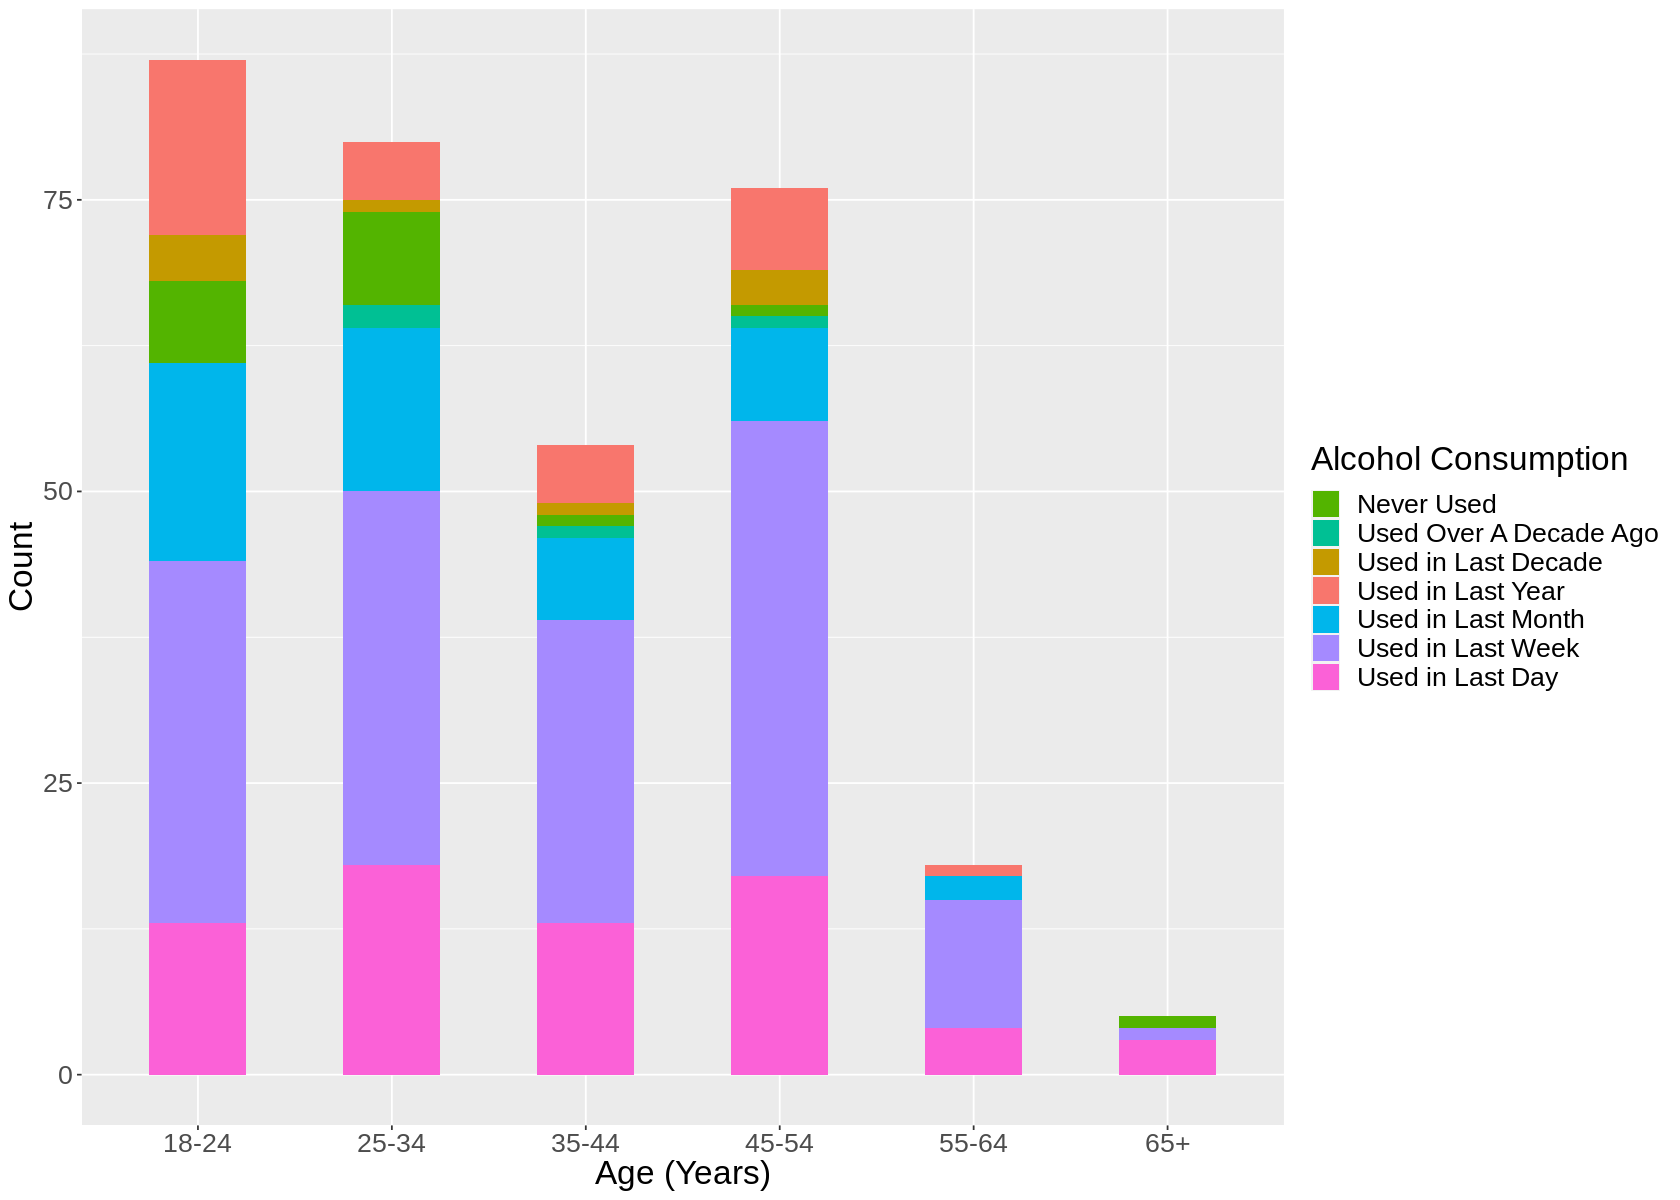

In [196]:
options(repr.plot.width = 14, repr.plot.height = 10)
alcohol_plot_age <- ggplot(alcohol_train, aes(x = as_factor(Age), fill = as_factor(Alcohol))) +
  geom_bar(width = 0.5) +
theme(text = element_text(size = 20)) + 
        scale_x_discrete(breaks = c("2.59171", "1.82213", "1.09449", "0.49788", "-0.07854", "-0.95197"),
                   labels = c("65+", "55-64", "45-54", "35-44", "25-34", "18-24")) +
scale_fill_discrete(breaks = c("CL0", "CL1", "CL2", "CL3", "CL4", "CL5", "CL6"),
                   labels = c("Never Used", "Used Over A Decade Ago", "Used in Last Decade", "Used in Last Year", 
                              "Used in Last Month", "Used in Last Week", "Used in Last Day")) +
                labs(x = "Age (Years)", y = "Count", fill = "Alcohol Consumption")
alcohol_plot_age

Now we will split the result based on alcohol consumption levels using histograms to find out the distribution of scores/measurements for different personality attributes among all individuals for each consumption level.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



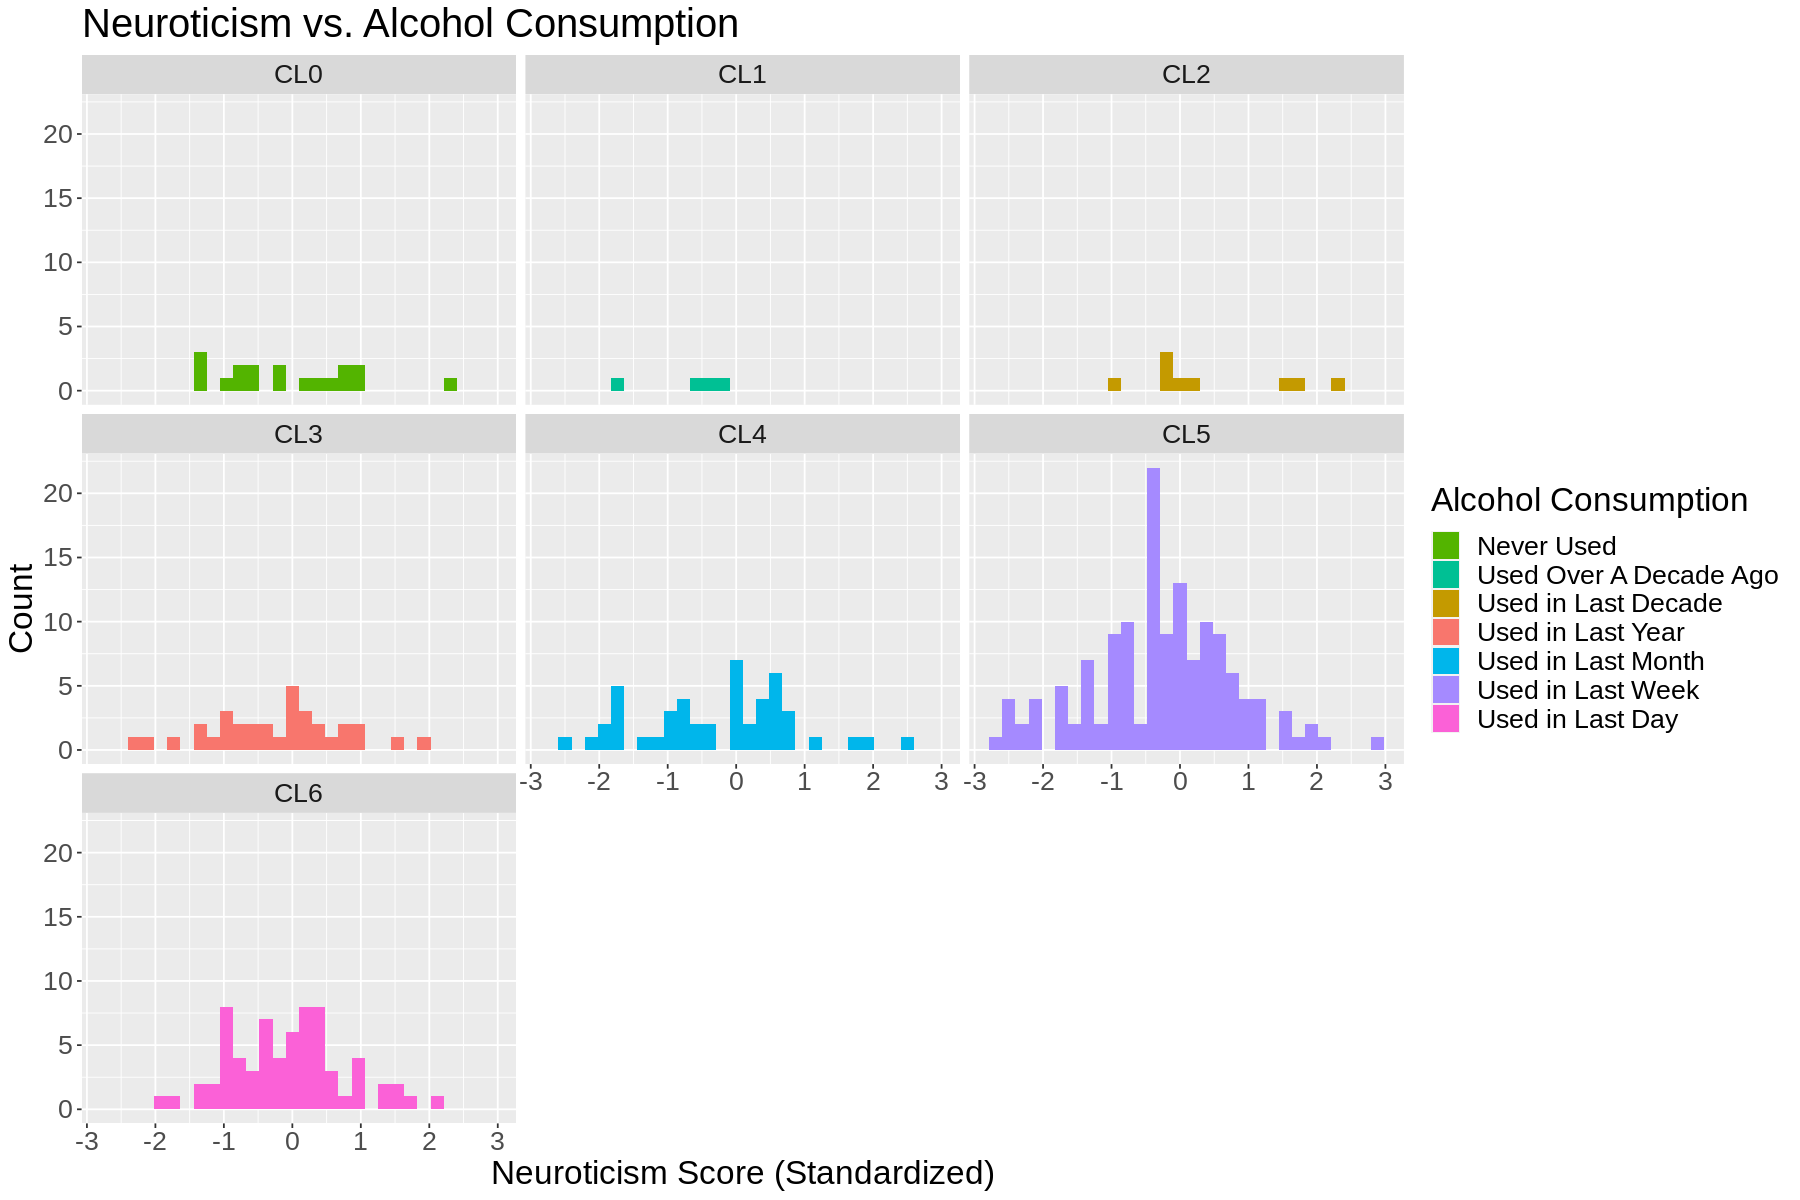

In [197]:
options(repr.plot.width = 15, repr.plot.height = 10)
nscore <- ggplot(alcohol_train, aes(x = Neuroticism, fill = as_factor(Alcohol))) +
          geom_histogram() + 
          scale_fill_discrete(breaks = c("CL0", "CL1", "CL2", "CL3", "CL4", "CL5", "CL6"),
                            labels = c("Never Used", "Used Over A Decade Ago", "Used in Last Decade", "Used in Last Year", 
                                      "Used in Last Month", "Used in Last Week", "Used in Last Day")) +
          labs(x = "Neuroticism Score (Standardized)", y = "Count", fill = "Alcohol Consumption") +
          facet_wrap(vars(Alcohol)) +
          ggtitle("Neuroticism vs. Alcohol Consumption") +
          theme(text = element_text(size = 20))

nscore

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



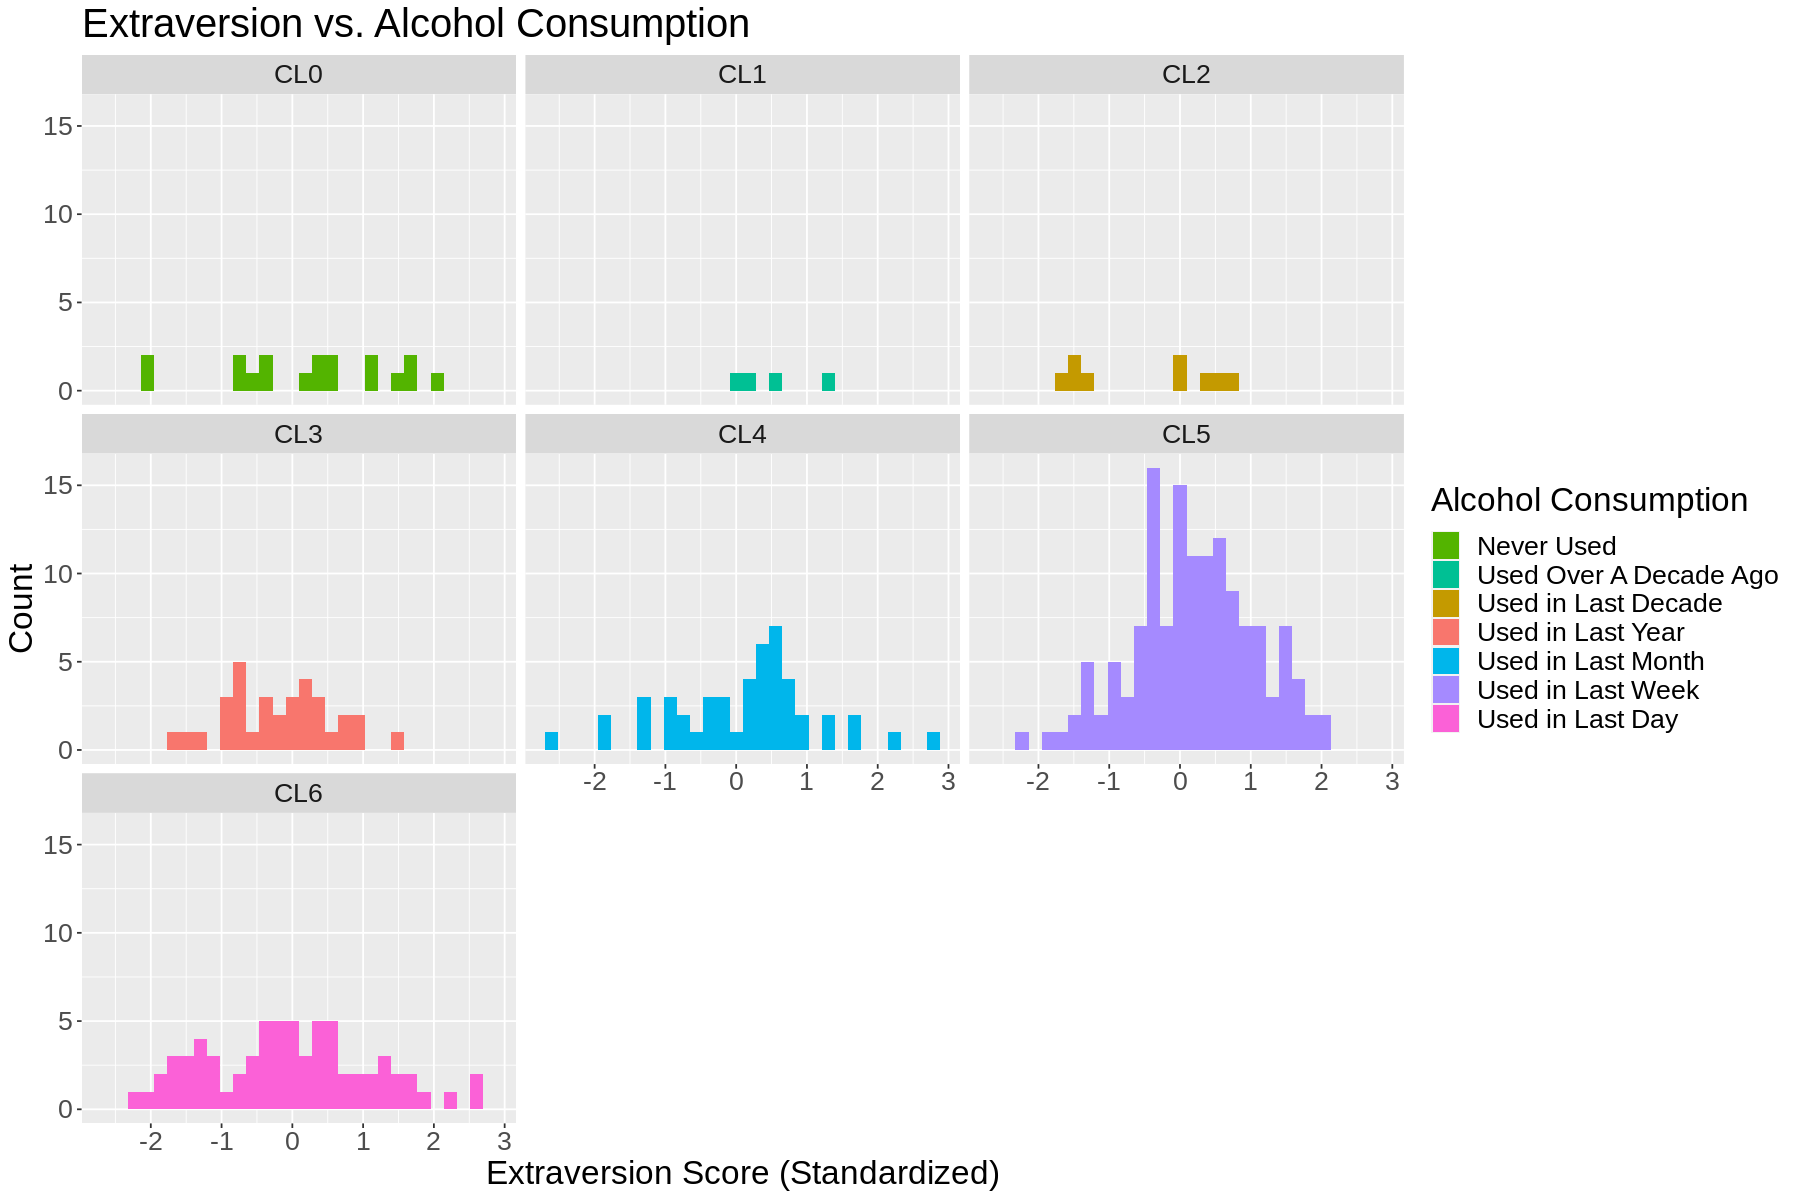

In [198]:
escore <- ggplot(alcohol_train, aes(x = Extraversion, fill = as_factor(Alcohol))) +
          geom_histogram() + 
          scale_fill_discrete(breaks = c("CL0", "CL1", "CL2", "CL3", "CL4", "CL5", "CL6"),
                            labels = c("Never Used", "Used Over A Decade Ago", "Used in Last Decade", "Used in Last Year", 
                                      "Used in Last Month", "Used in Last Week", "Used in Last Day")) +
          labs(x = "Extraversion Score (Standardized)", y = "Count", fill = "Alcohol Consumption") +
          facet_wrap(vars(Alcohol)) +
          ggtitle("Extraversion vs. Alcohol Consumption") +
          theme(text = element_text(size = 20))

escore

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



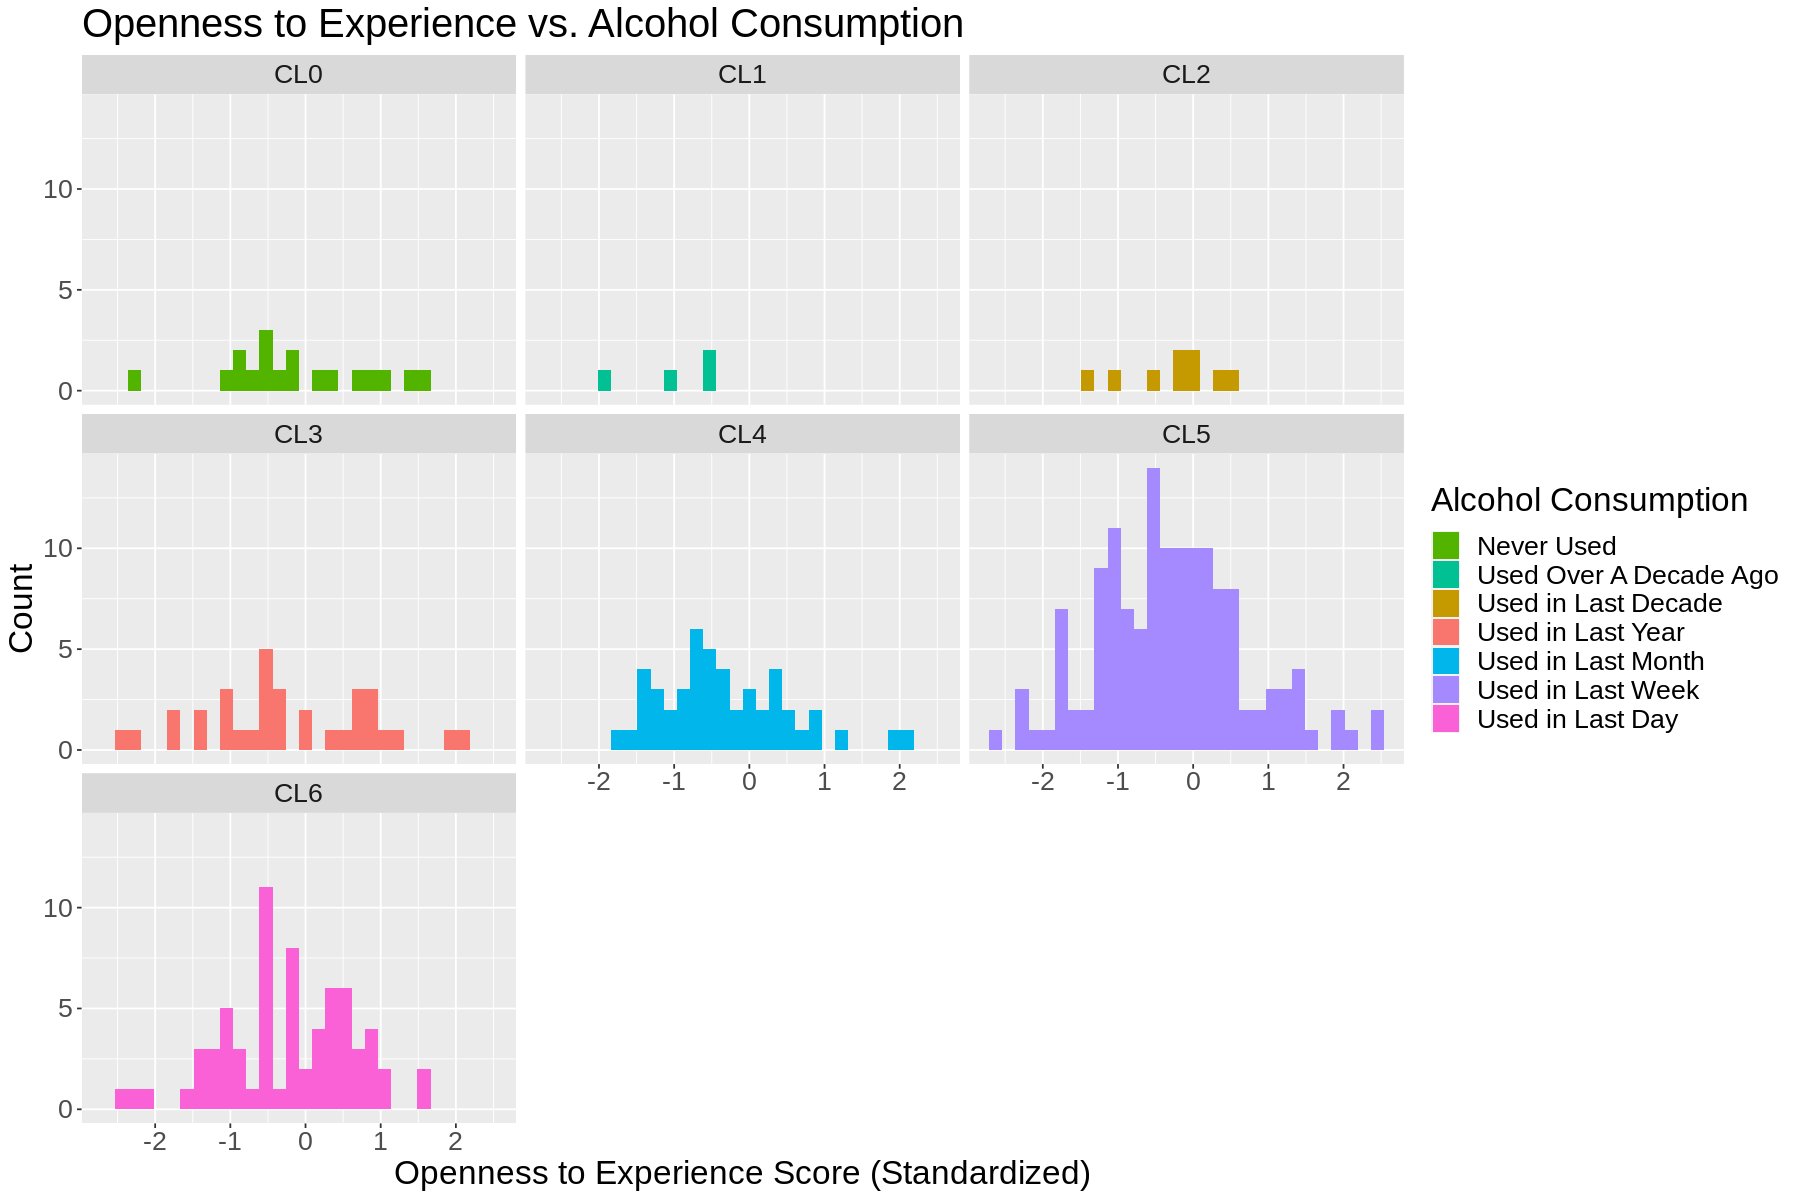

In [199]:
oscore <- ggplot(alcohol_train, aes(x = Openness_to_Experience, fill = as_factor(Alcohol))) +
          geom_histogram() + 
          scale_fill_discrete(breaks = c("CL0", "CL1", "CL2", "CL3", "CL4", "CL5", "CL6"),
                            labels = c("Never Used", "Used Over A Decade Ago", "Used in Last Decade", "Used in Last Year", 
                                      "Used in Last Month", "Used in Last Week", "Used in Last Day")) +
          labs(x = "Openness to Experience Score (Standardized)", y = "Count", fill = "Alcohol Consumption") +
          facet_wrap(vars(Alcohol)) +
          ggtitle("Openness to Experience vs. Alcohol Consumption") +
          theme(text = element_text(size = 20))

oscore

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



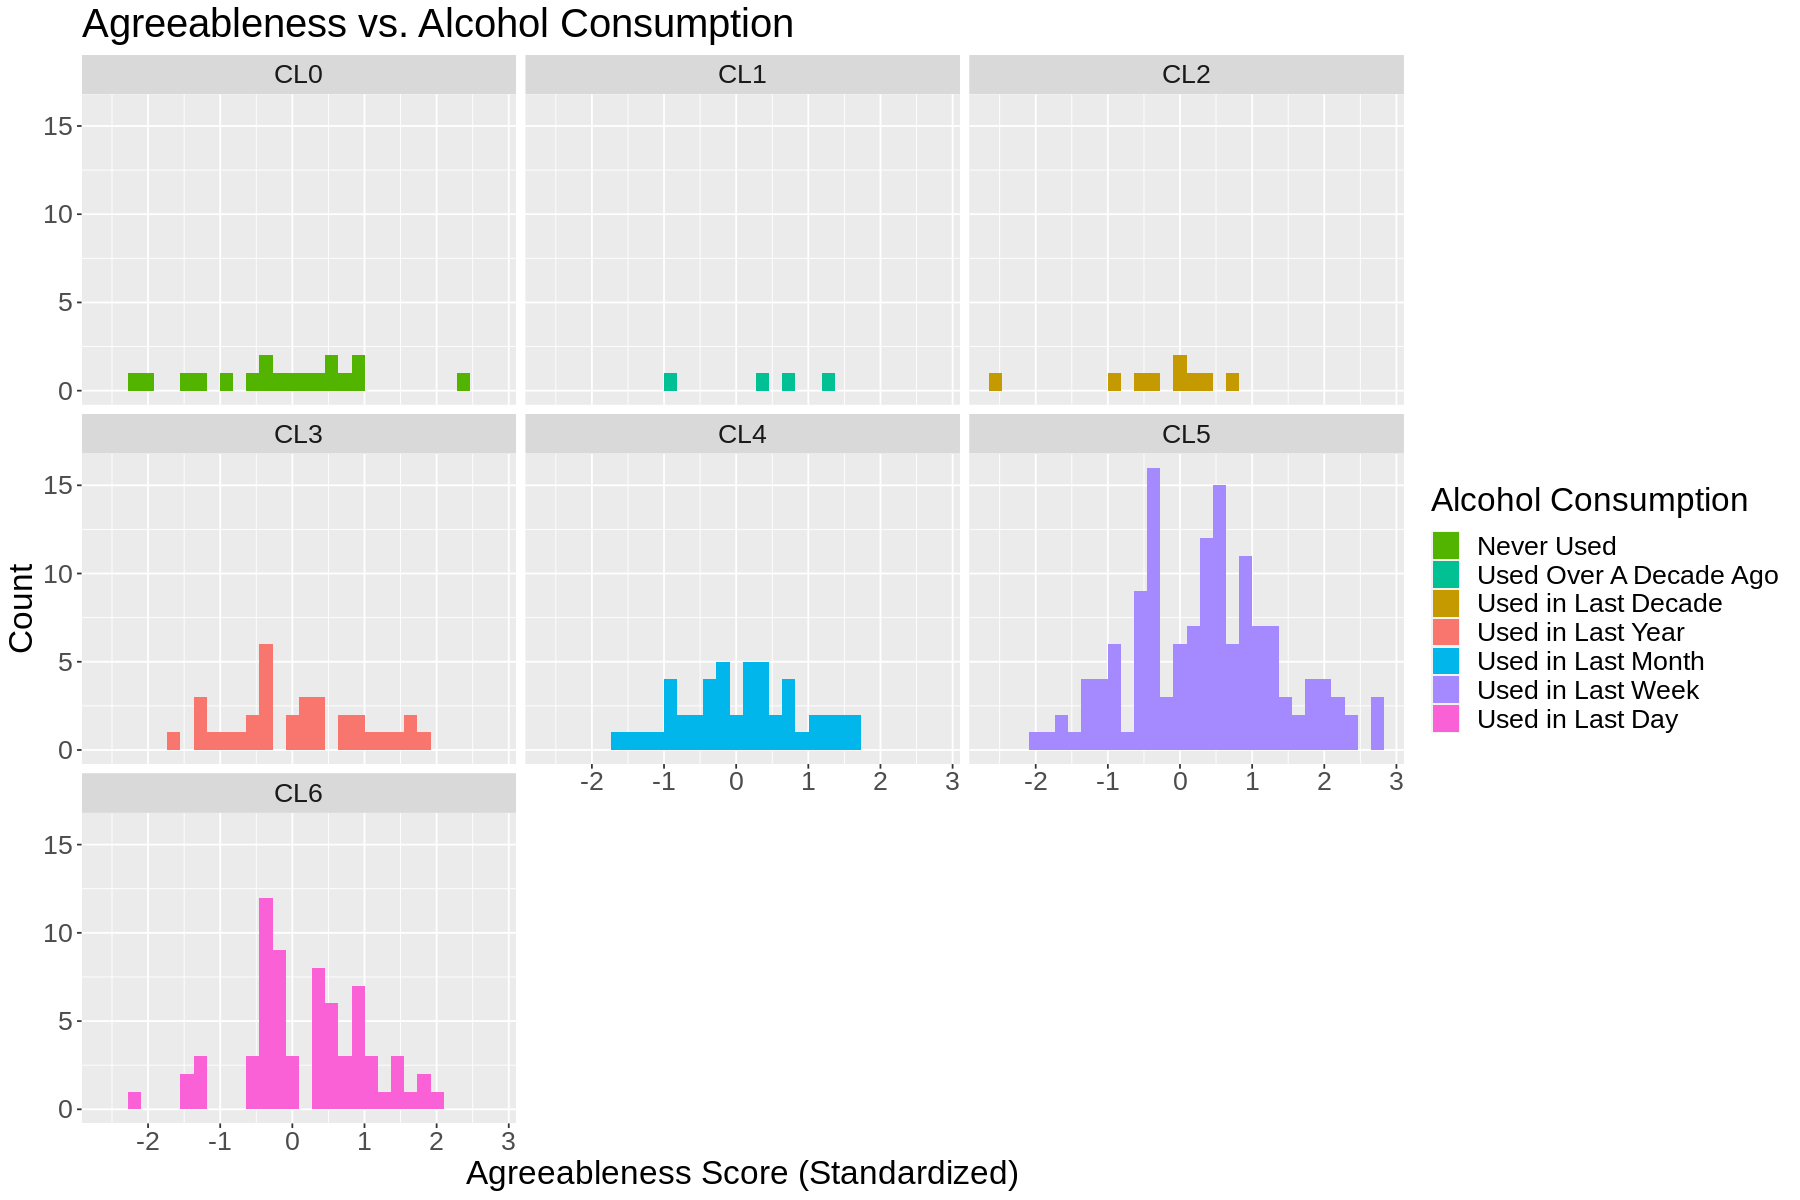

In [200]:
ascore <- ggplot(alcohol_train, aes(x = Agreeableness, fill = as_factor(Alcohol))) +
          geom_histogram() + 
          scale_fill_discrete(breaks = c("CL0", "CL1", "CL2", "CL3", "CL4", "CL5", "CL6"),
                            labels = c("Never Used", "Used Over A Decade Ago", "Used in Last Decade", "Used in Last Year", 
                                      "Used in Last Month", "Used in Last Week", "Used in Last Day")) +
          labs(x = "Agreeableness Score (Standardized)", y = "Count", fill = "Alcohol Consumption") +
          facet_wrap(vars(Alcohol)) +
          ggtitle("Agreeableness vs. Alcohol Consumption") +
          theme(text = element_text(size = 20))

ascore

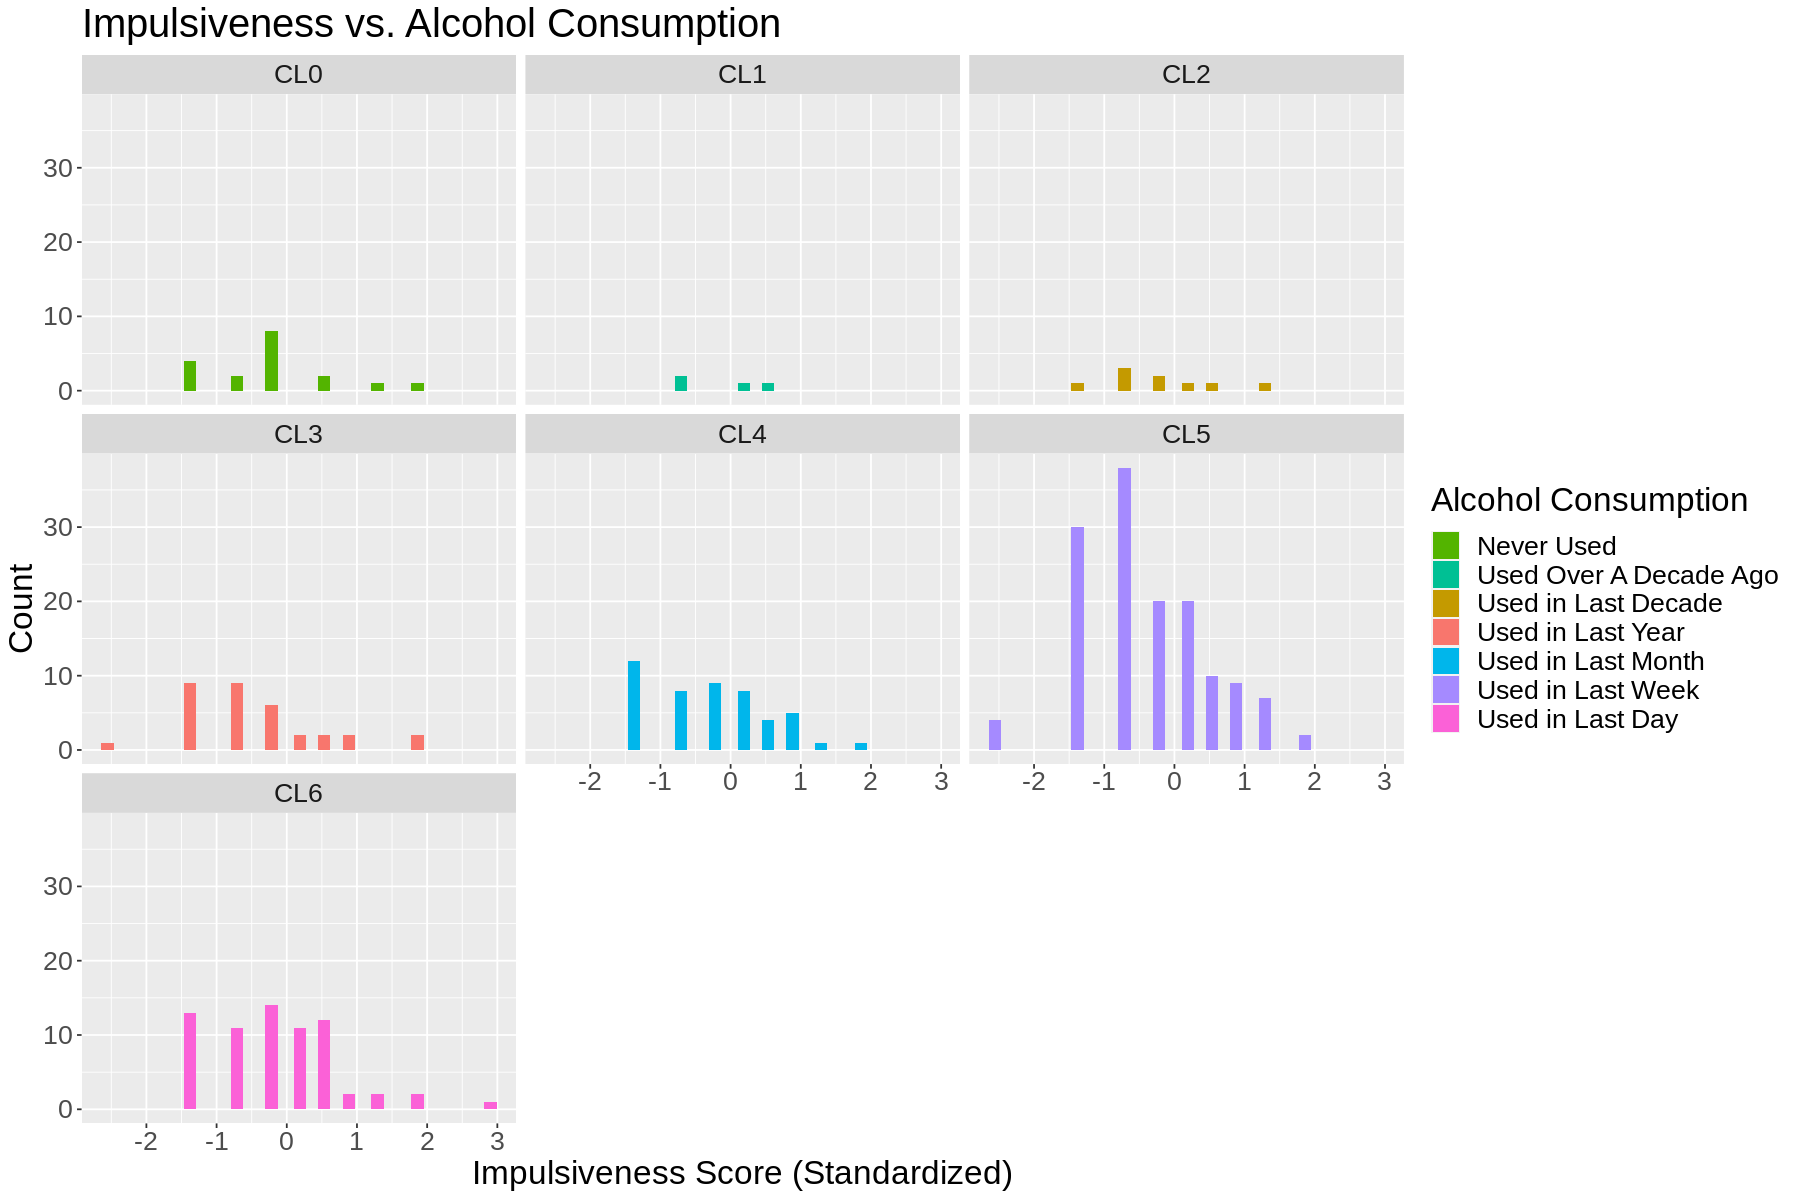

In [201]:
iscore <- ggplot(alcohol_train, aes(x = Impulsiveness, fill = as_factor(Alcohol))) +
          geom_bar() + 
          scale_fill_discrete(breaks = c("CL0", "CL1", "CL2", "CL3", "CL4", "CL5", "CL6"),
                            labels = c("Never Used", "Used Over A Decade Ago", "Used in Last Decade", "Used in Last Year", 
                                      "Used in Last Month", "Used in Last Week", "Used in Last Day")) +
          labs(x = "Impulsiveness Measurement (Standardized)", y = "Count", fill = "Alcohol Consumption") +
          facet_wrap(vars(Alcohol)) +
          ggtitle("Impulsiveness vs. Alcohol Consumption") +
          theme(text = element_text(size = 20))

iscore

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



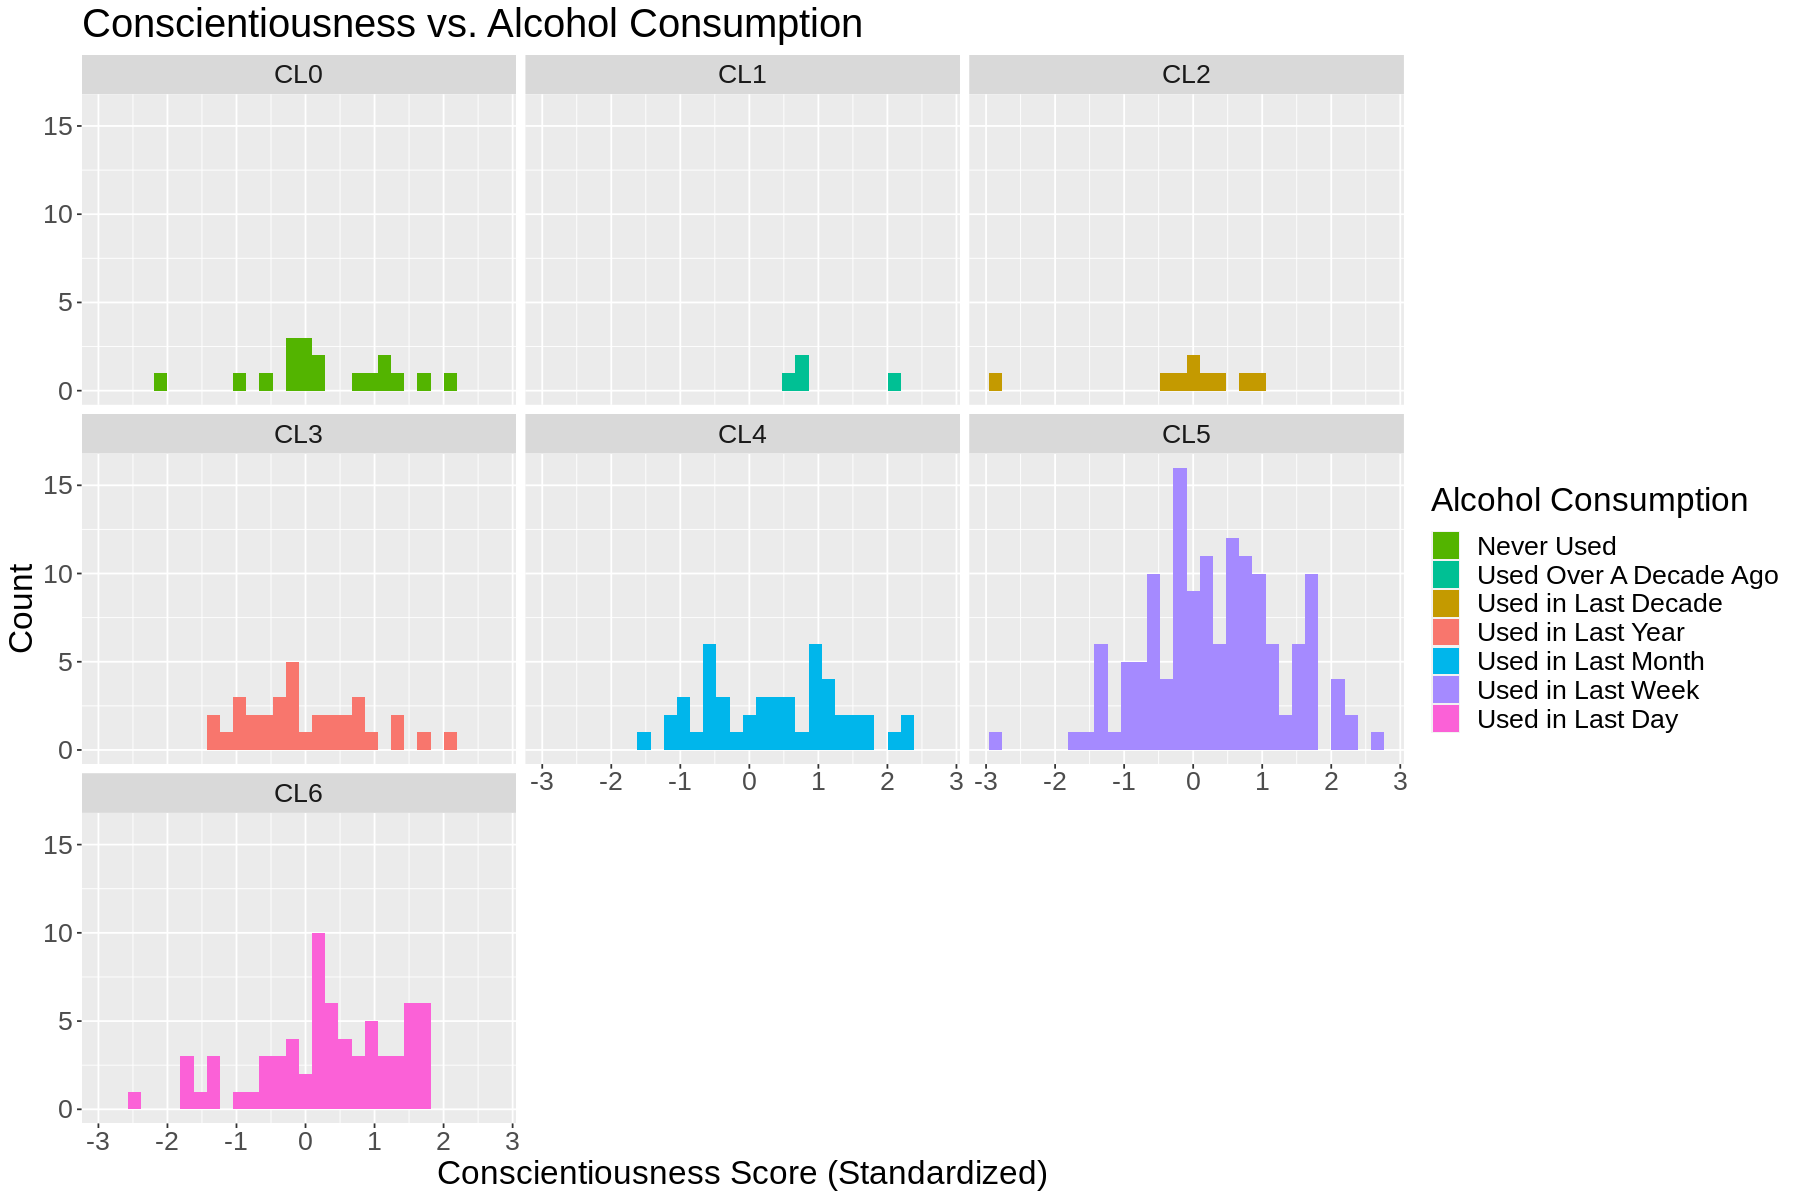

In [202]:
cscore <- ggplot(alcohol_train, aes(x = Conscientiousness, fill = as_factor(Alcohol))) +
          geom_histogram() + 
          scale_fill_discrete(breaks = c("CL0", "CL1", "CL2", "CL3", "CL4", "CL5", "CL6"),
                            labels = c("Never Used", "Used Over A Decade Ago", "Used in Last Decade", "Used in Last Year", 
                                      "Used in Last Month", "Used in Last Week", "Used in Last Day")) +
          labs(x = "Conscientiousness Score (Standardized)", y = "Count", fill = "Alcohol Consumption") +
          facet_wrap(vars(Alcohol)) +
          ggtitle("Conscientiousness vs. Alcohol Consumption") +
          theme(text = element_text(size = 20))

cscore

In all the plots above, we can observe that the dataset is well distributed among all classes for all the personality traits which confirms that this dataset is ideal for a classification problem.

## Methods

We will predict our result by classification. Firstly, we will standardize the data again and to choose the best predictors for our analysis, we will be using forward selection in R. Then we will create a recipe with these predictors and set `Alcohol` as our target variable. We will create a model using the kknn engine, a rectangular weight function, and the optimal number of neighbours determined from five-fold cross-validation. Finally, we will create a workflow using the model and recipe we have created so far to make the predictions, and visualize them with a bar graph.

In our graph, we will have two vertical bars side by side for each class. One bar will be the true count of the class inside the test data while the other bar will represent the number of times the class appeared when we predicted the entire test data with our classifier. This visualization is effective as it makes it easy to deduce the accuracy of our classifier. The closer in heights the two bars are for all the classes, the more accurate our classifier is.

## Expected Outcomes and Significance:

Through our analysis, we expect to find a correlation between our selected predictors and alcohol consumption. By finding the correlation, alcohol prevention programs can better target individuals who match the traits of a high alcohol consumer. Conversely, advertisements by alcohol companies can also better target these individuals to boost sales. Ultimately, our outcome could lead to many future questions, most significantly, why these variables affect the consumption of alcohol and could help obtain a much better understanding of the drug. 


## References
UCI Machine Learning Repository: Drug Consumption (Quantified) Data Set. archive.ics.uci.edu/ml/datasets/Drug+consumption+(quantified). Accessed 29 Oct. 2022.

Campbell, et al. Data Science: A First Introduction. 1st ed., CRC Press, 2022, datasciencebook.ca/about-the-authors.html.

Fehrman, Elaine, et al. “Personal Traits.” Personality Traits and Drug Consumption a Story Told by Data, Springer International Publishing, Cham, 2019.